# `山火事の消失面積予測`

## `概要`

### 不快指数や風速などの気象データ等から、ポルトガル北東部の森林火災消失面積を予測する

## `評価方法`

### 評価関数「RMSE」を使用

## `説明変数・目的変数`

+ X:モンテジーニョ公園の地図内のx軸の空間座標

+ y:モンテジーニョ公園の地図内のy軸の空間座標

+ month:月

+ day:曜日

+ FFMC:FFMC指数（ゴミ及びその他の硬化した微細燃料の含水量を数値で評価したもの）

+ DMC:DMC指数（過度な深さの緩やかに圧縮された有機層の平均含水量の数値評価）

+ DC:DC指数（深くてコンパクトな有機そうの平均含水量を数値で表したもの）

+ ISI:ISI指数（予想される火災伝搬率の数値評価）

+ temp:気温(摂氏)

+ RH:相対湿度

+ wind:風速

+ rain:降水量

+ area:森林の消失面積

---

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
import math

In [119]:
train = pd.read_csv("train.tsv", index_col=0, sep="\t")
test = pd.read_csv("test.tsv", index_col=0, sep="\t")
data = pd.concat([train,test], axis=0)

In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    258 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 56.5+ KB


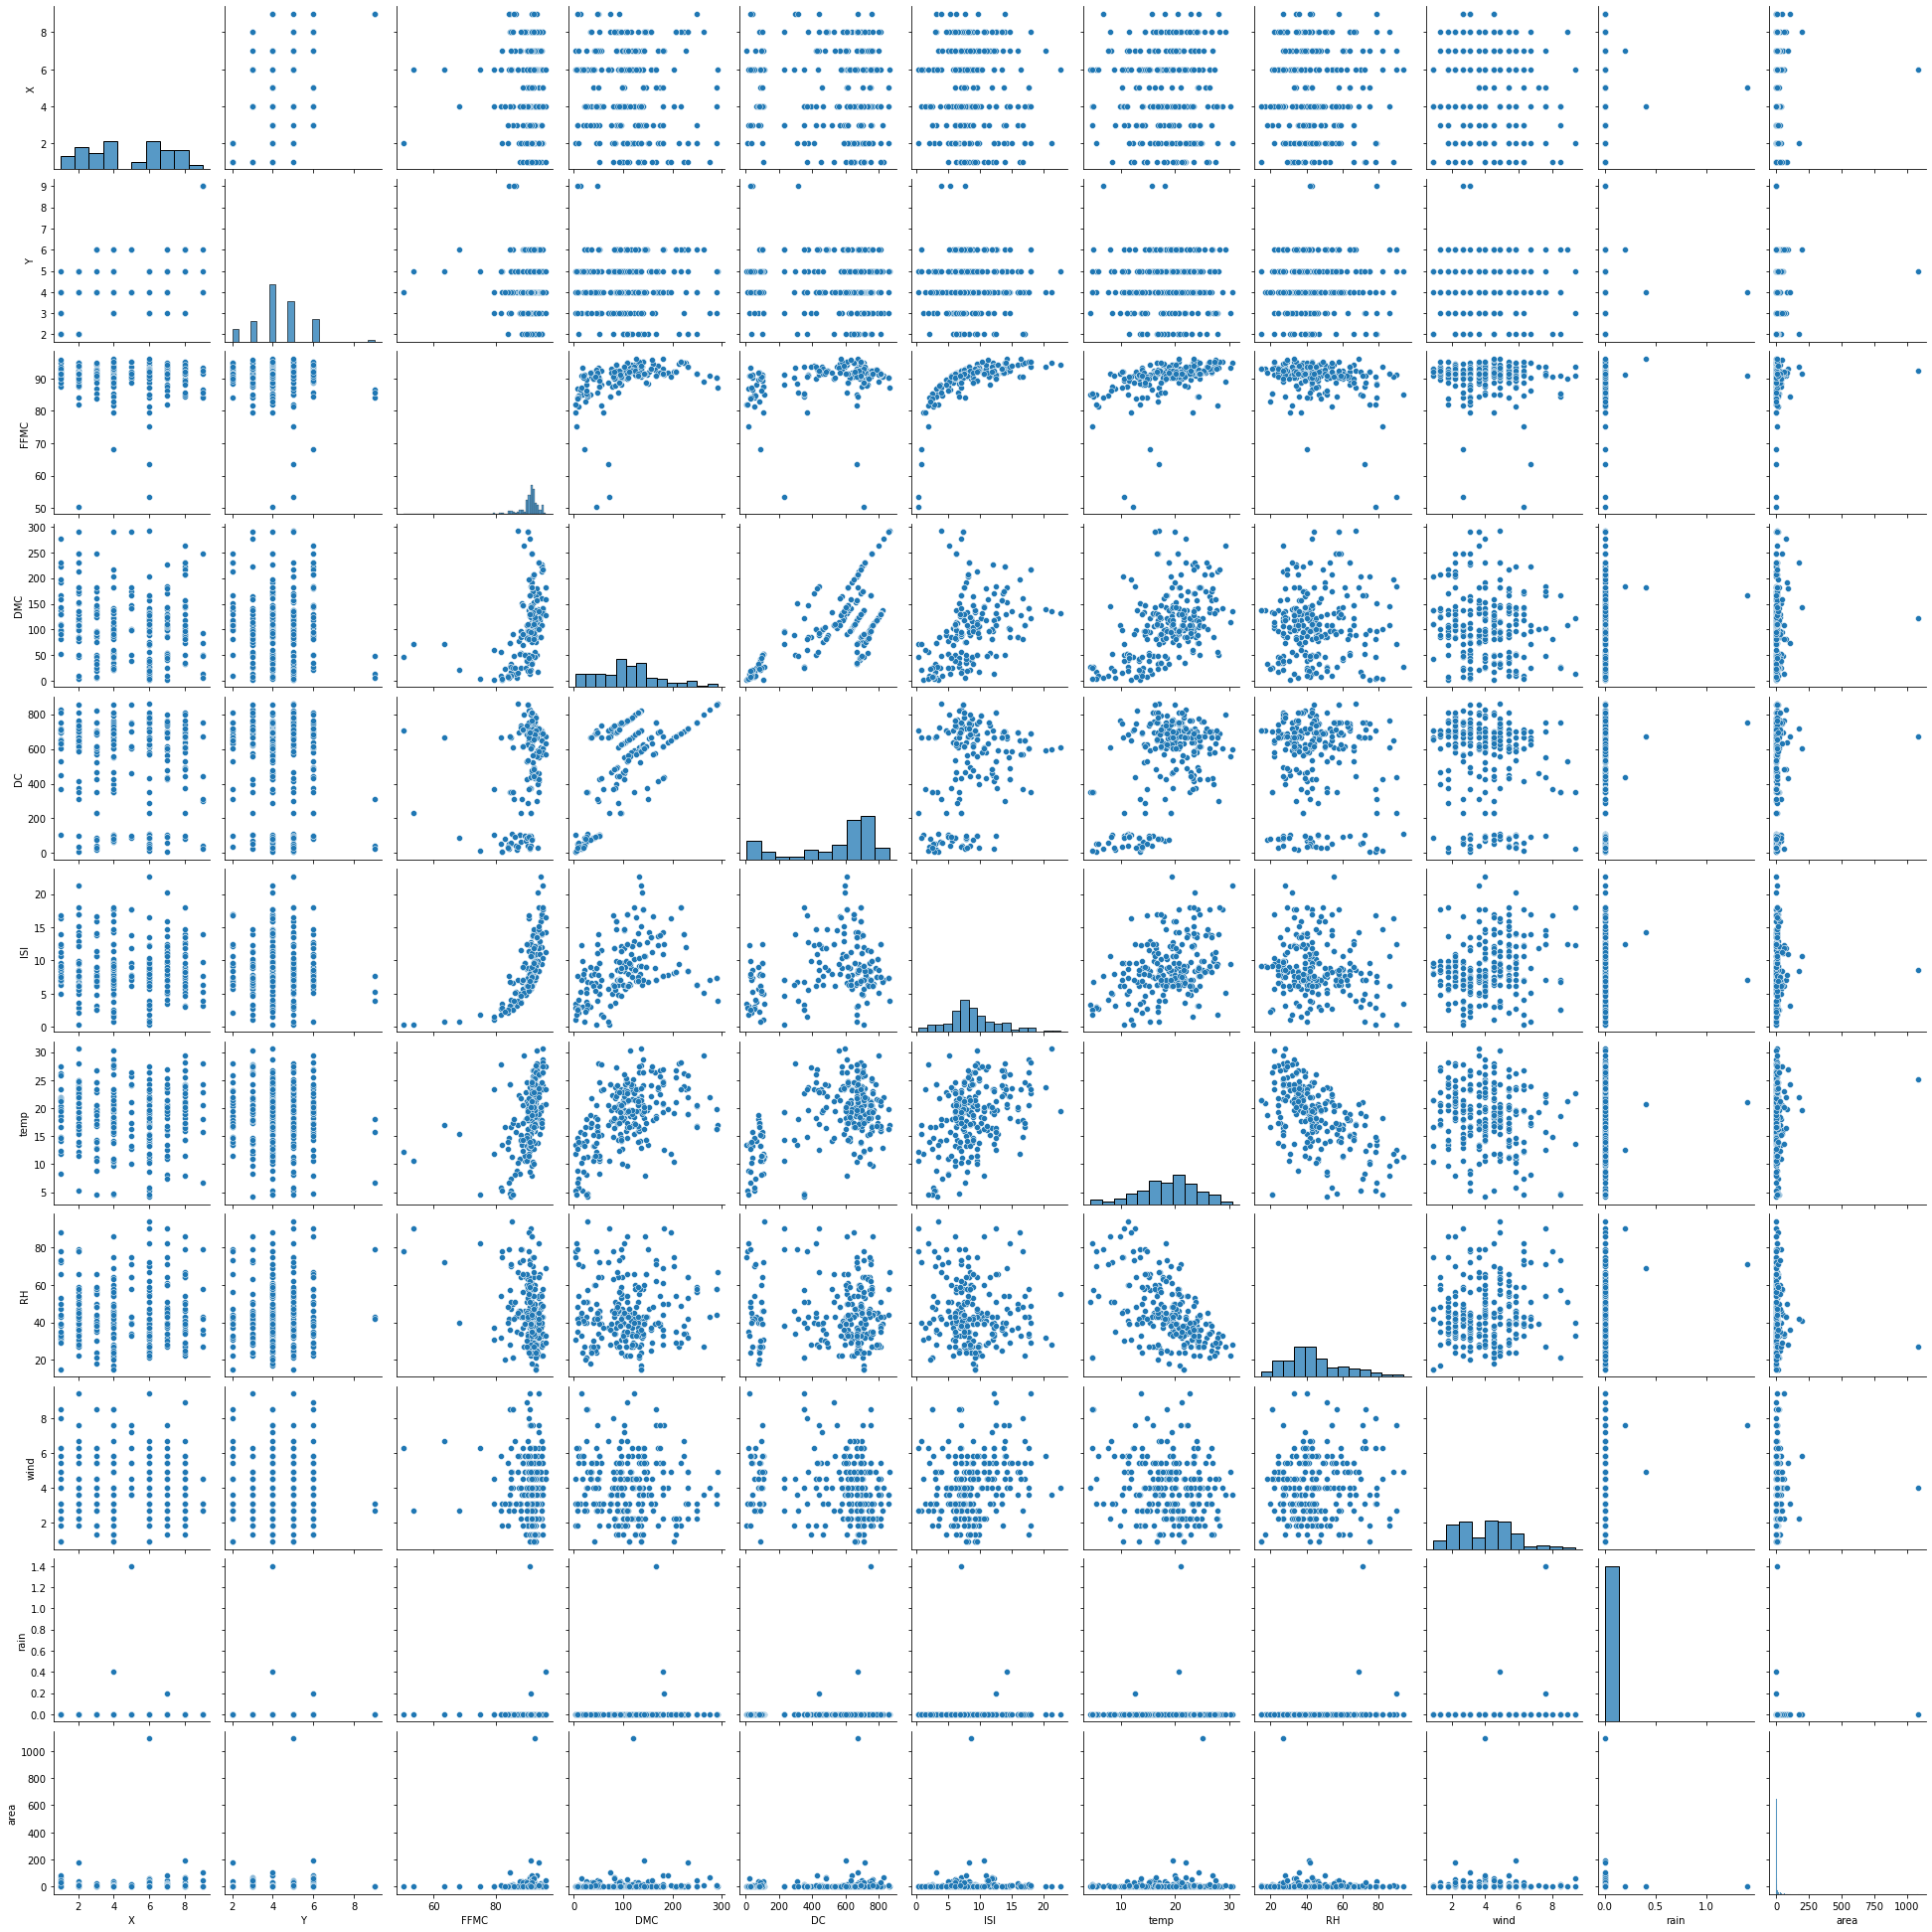

In [121]:
sns.pairplot(train)

---
# `month,dayのカテゴリカル変数処理`

### 曜日は関係ないので削除

In [122]:
train.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
id,,,,,,,,,,,,,
0,2,4,sep,sun,92.4,105.8,758.1,9.9,16.0,45,1.8,0.0,0.00
3,7,4,aug,sun,91.6,181.3,613.0,7.6,19.3,61,4.9,0.0,0.00
9,7,4,sep,fri,92.1,99.0,745.3,9.6,19.8,47,2.7,0.0,1.72
11,7,4,aug,fri,94.8,227.0,706.7,12.0,23.3,34,3.1,0.0,0.00
13,4,3,sep,mon,91.6,108.4,764.0,6.2,9.8,86,1.8,0.0,0.00


In [123]:
# month処理
month_dic = {"jan":1,"feb":2,"mar":3,"apr":4,"may":5,"jun":6,"jul":7,"aug":8,
             "sep":9,"oct":10,"nov":11,"dec":12}
for i in train.index:
    train["month"][i] = month_dic[train["month"][i]]

for i in test.index:
    test["month"][i] = month_dic[test["month"][i]]

# monthの型をobjectからintへ
train["month"] = train["month"].astype(int)
test["month"] = test["month"].astype(int)

# dayを削除
train = train.drop(['day'], axis=1)
test = test.drop(['day'], axis=1)

In [124]:
train.head()

,X,Y,month,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
id,,,,,,,,,,,,
0,2,4,9,92.4,105.8,758.1,9.9,16.0,45,1.8,0.0,0.00
3,7,4,8,91.6,181.3,613.0,7.6,19.3,61,4.9,0.0,0.00
9,7,4,9,92.1,99.0,745.3,9.6,19.8,47,2.7,0.0,1.72
11,7,4,8,94.8,227.0,706.7,12.0,23.3,34,3.1,0.0,0.00
13,4,3,9,91.6,108.4,764.0,6.2,9.8,86,1.8,0.0,0.00


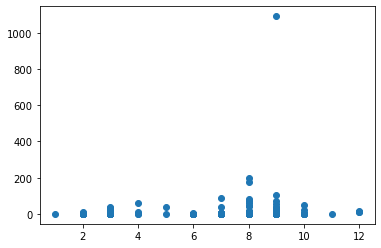

In [125]:
# 訓練データでの月とareaの関係
plt.scatter(train.month, train.area)

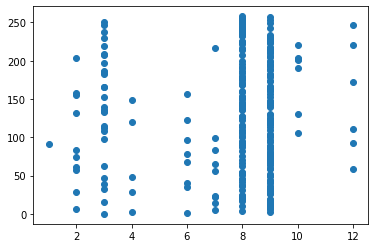

In [126]:
# テストデータの月
plt.scatter(test.month,range(259))

In [127]:
# 訓練データの外れ値
train[train.area == 1090.84]

,X,Y,month,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
id,,,,,,,,,,,,
174,6,5,9,92.5,121.1,674.4,8.6,25.1,27,4.0,0.0,1090.84


+ 暑い（7,8,9月あたり）と消失面積多くなる

##  `訓練データ9月の外れ値が外せるかどうか４分位範囲を調べる`

In [128]:
def identify_outliers(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    # 下限
    lower_bound = quartile_1 - (iqr * 1.5)
    # 上限
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.array(ys)[((ys > upper_bound) | (ys < lower_bound))]

identify_outliers(train.area)

array([  70.76,   29.48,   28.66,   20.03,   17.2 ,   30.18,   37.02,
         61.13,   38.48,   49.37, 1090.84,   17.85,   86.45,   71.3 ,
         27.35,  196.48,   82.75,   56.04,   36.85,   26.13,  105.66,
         24.23,   39.35,   42.87,  174.63,   24.59,   19.23,   16.4 ,
         30.32,   31.86,   16.  ,   58.3 ,   43.32,   28.19])

---
##  `訓練データ9月の外れ値を外す`

In [181]:
train = train[train.area!=1090.84]
train = train[train.area!=196.48]
train = train[train.area!=174.63]
train = train[train.area!=105.66]

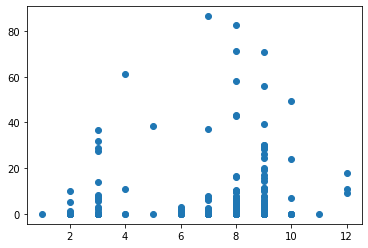

In [182]:
# 訓練データでの月とareaの関係
plt.scatter(train.month, train.area)

### 月とareaの関係から分かること
+ 8,9月の消失面積が多い
+ 1, 2, 6, 11月の消失面積はほぼ0

In [183]:
# 8,9月、 1,2,6,11月、 3,4,5,7,10,12月のグループで分ける
wide_area_month = [8, 9]
no_area_month = [1, 2, 6, 11]
others = [3, 4, 5, 7, 10, 12]
train['wide_area_month']=train['month'].apply(lambda x : 1 if x in wide_area_month else 0)
train['no_area_month']=train['month'].apply(lambda x : 1 if x in no_area_month else 0)
train['others_area_month']=train['month'].apply(lambda x : 1 if x in others else 0)

In [184]:
test['wide_area_month']=test['month'].apply(lambda x : 1 if x in wide_area_month else 0)
test['no_area_month']=test['month'].apply(lambda x : 1 if x in no_area_month else 0)
test['others_area_month']=test['month'].apply(lambda x : 1 if x in others else 0)

---
## `カラム同士で相関が高いものはないか？（あったらどちらかを削除）`

<AxesSubplot:>

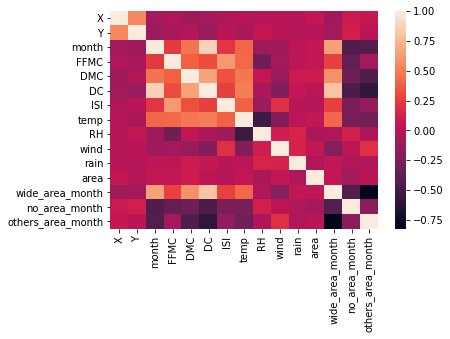

In [132]:
sns.heatmap(train.corr())

In [133]:
train.corr()

,X,Y,month,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,wide_area_month,no_area_month,others_area_month
X,1.000000,0.545929,-0.075897,-0.036149,-0.104435,-0.094985,-0.030832,-0.007836,0.000181,-0.003030,0.008337,0.052095,-0.105659,0.084624,0.061386
Y,0.545929,1.000000,-0.108854,-0.062462,-0.020866,-0.120559,0.004274,-0.049724,0.052628,0.007426,-0.008012,-0.010629,-0.084462,0.120409,0.015988
month,-0.075897,-0.108854,1.000000,0.249737,0.466471,0.875153,0.225235,0.410202,-0.102211,-0.108428,0.019285,0.049996,0.653100,-0.443131,-0.429567
FFMC,-0.036149,-0.062462,0.249737,1.000000,0.391208,0.323363,0.619283,0.429233,-0.314865,-0.078464,0.027538,0.047679,0.277409,-0.358770,-0.075527
DMC,-0.104435,-0.020866,0.466471,0.391208,1.000000,0.663828,0.337737,0.487312,0.051656,-0.129633,0.082344,0.091625,0.586322,-0.312696,-0.439020
DC,-0.094985,-0.120559,0.875153,0.323363,0.663828,1.000000,0.268001,0.507318,-0.057069,-0.221638,0.057359,0.029012,0.809675,-0.454920,-0.591772
ISI,-0.030832,0.004274,0.225235,0.619283,0.337737,0.268001,1.000000,0.396843,-0.117194,0.204435,0.005657,-0.010120,0.279961,-0.247105,-0.148306
temp,-0.007836,-0.049724,0.410202,0.429233,0.487312,0.507318,0.396843,1.000000,-0.525156,-0.209787,0.024487,0.045099,0.418094,-0.259737,-0.290007
RH,0.000181,0.052628,-0.102211,-0.314865,0.051656,-0.057069,-0.117194,-0.525156,1.000000,0.109063,0.147615,-0.054019,-0.032887,0.129829,-0.045782
wind,-0.003030,0.007426,-0.108428,-0.078464,-0.129633,-0.221638,0.204435,-0.209787,0.109063,1.000000,0.145512,0.039795,-0.203546,0.024330,0.205219


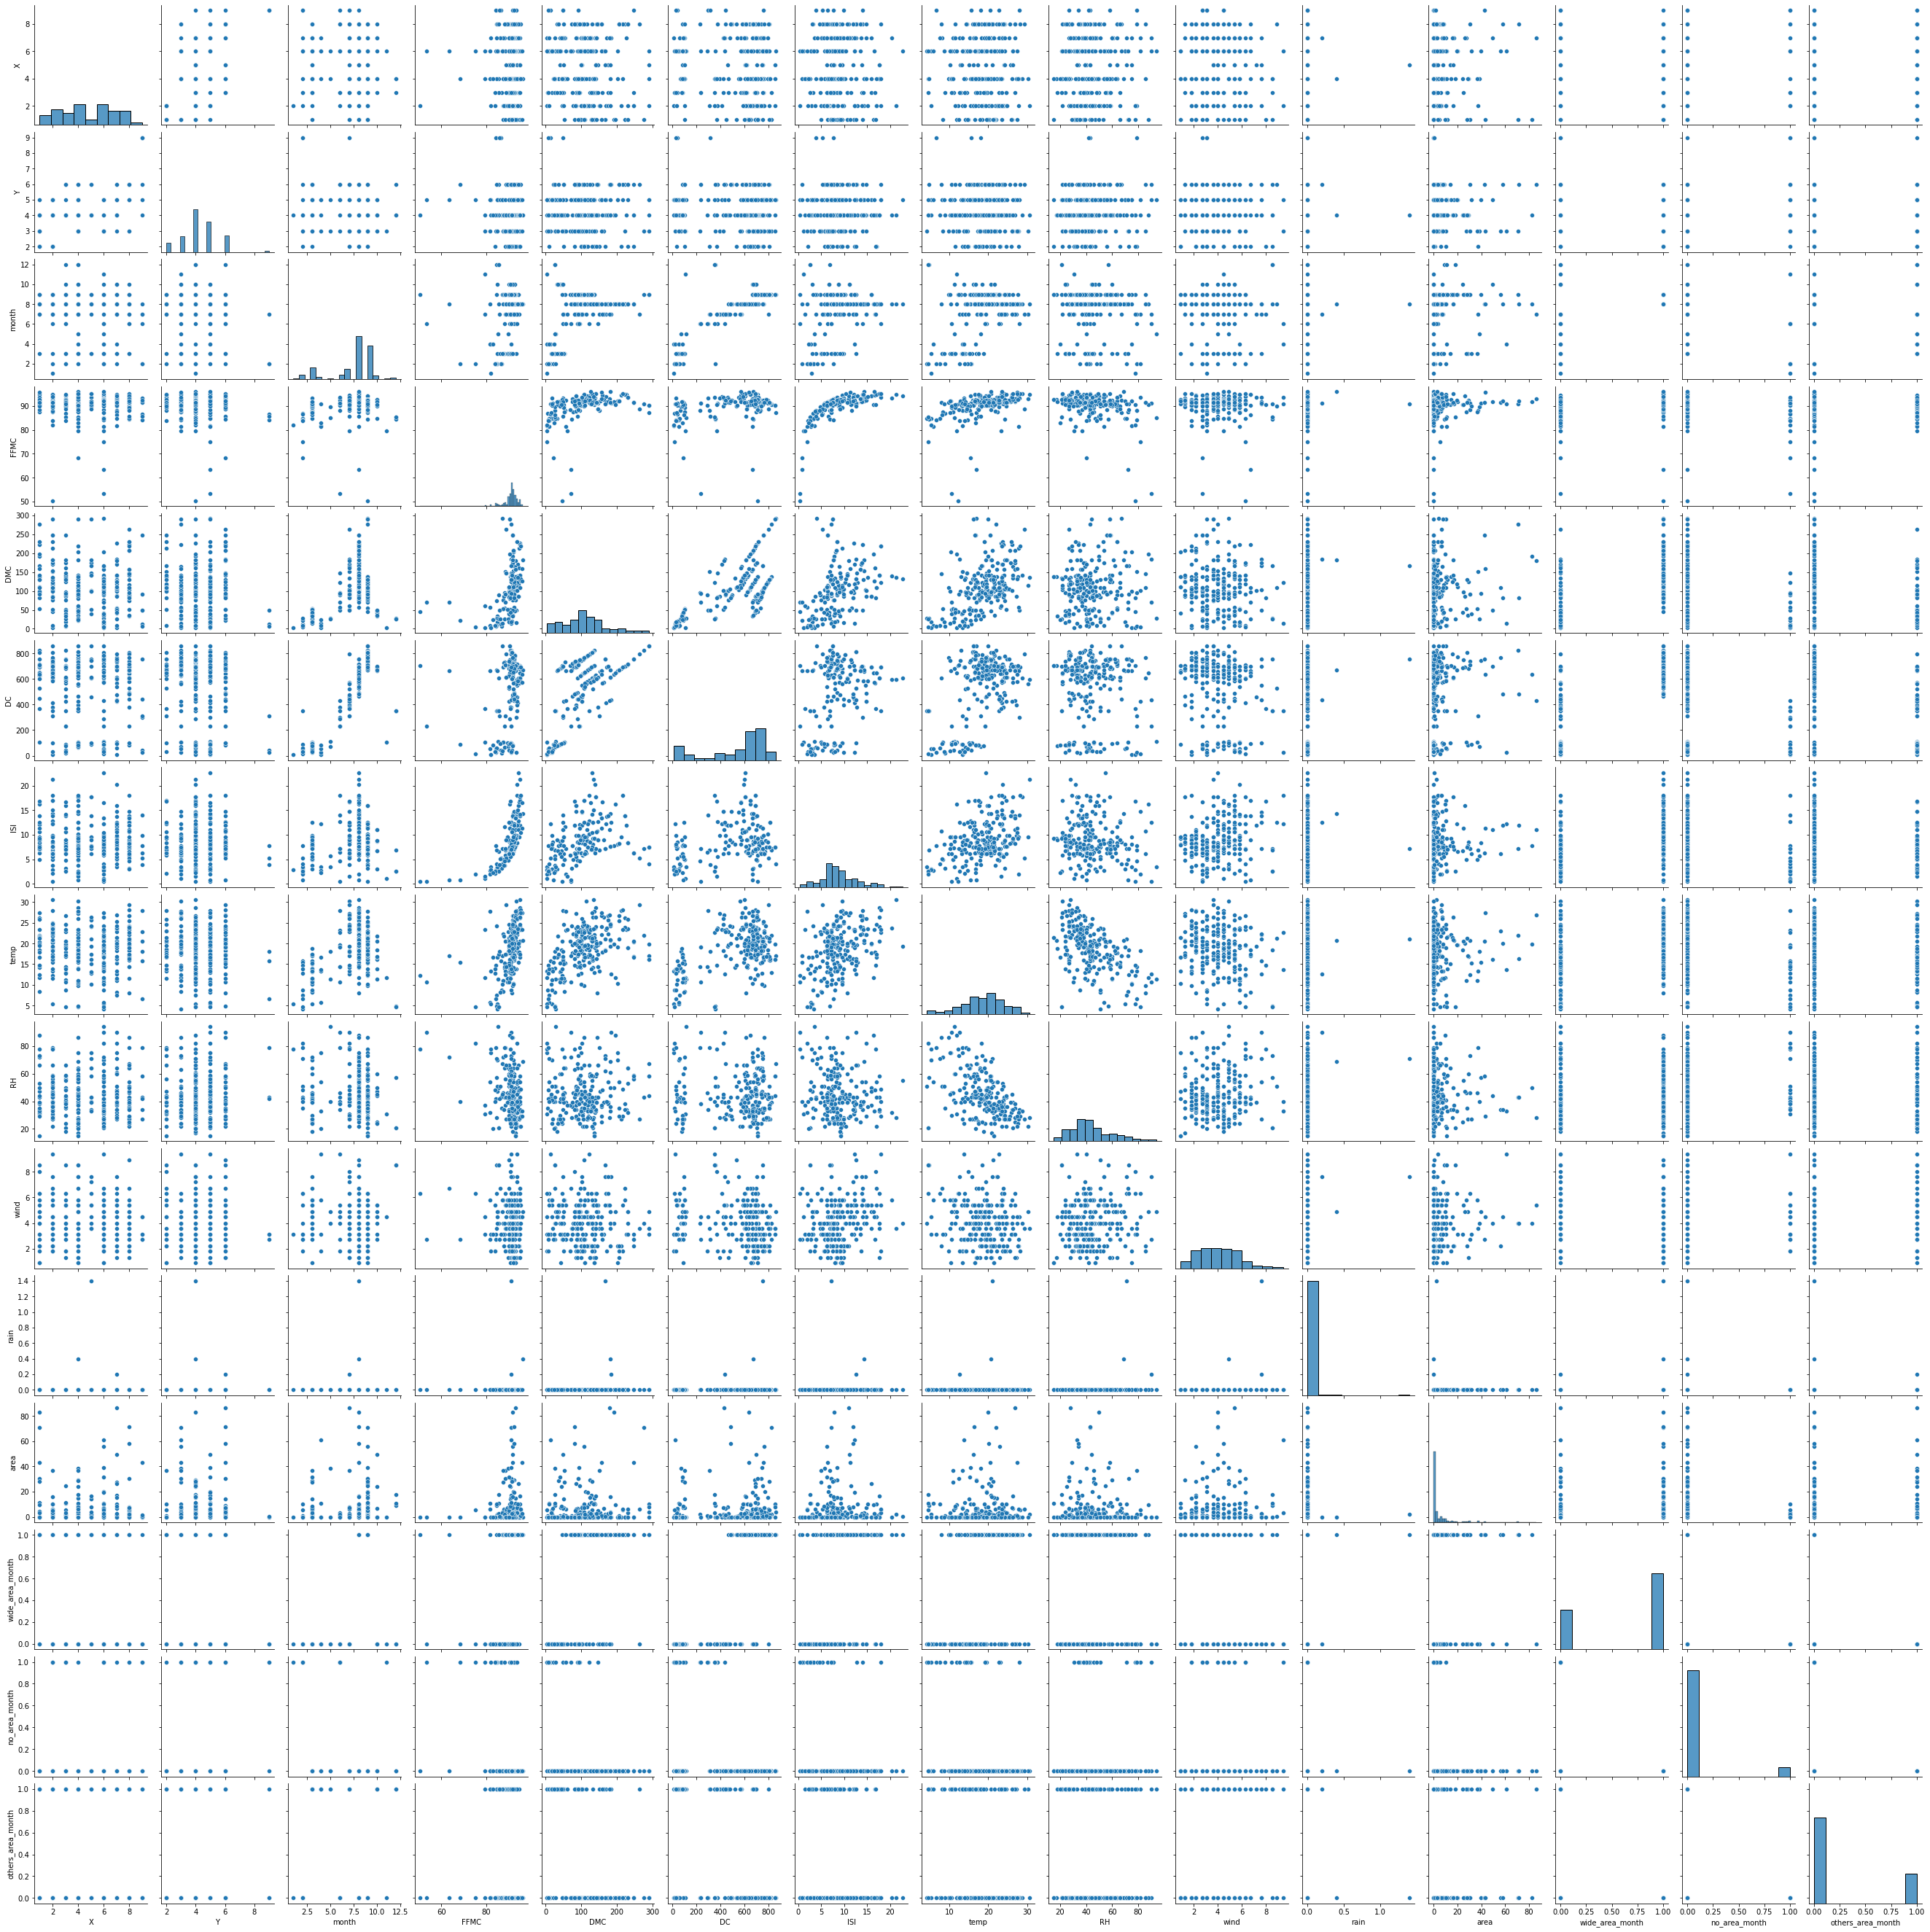

In [198]:
sns_plot = sns.pairplot(train)
sns_plot.savefig("img_train.png")

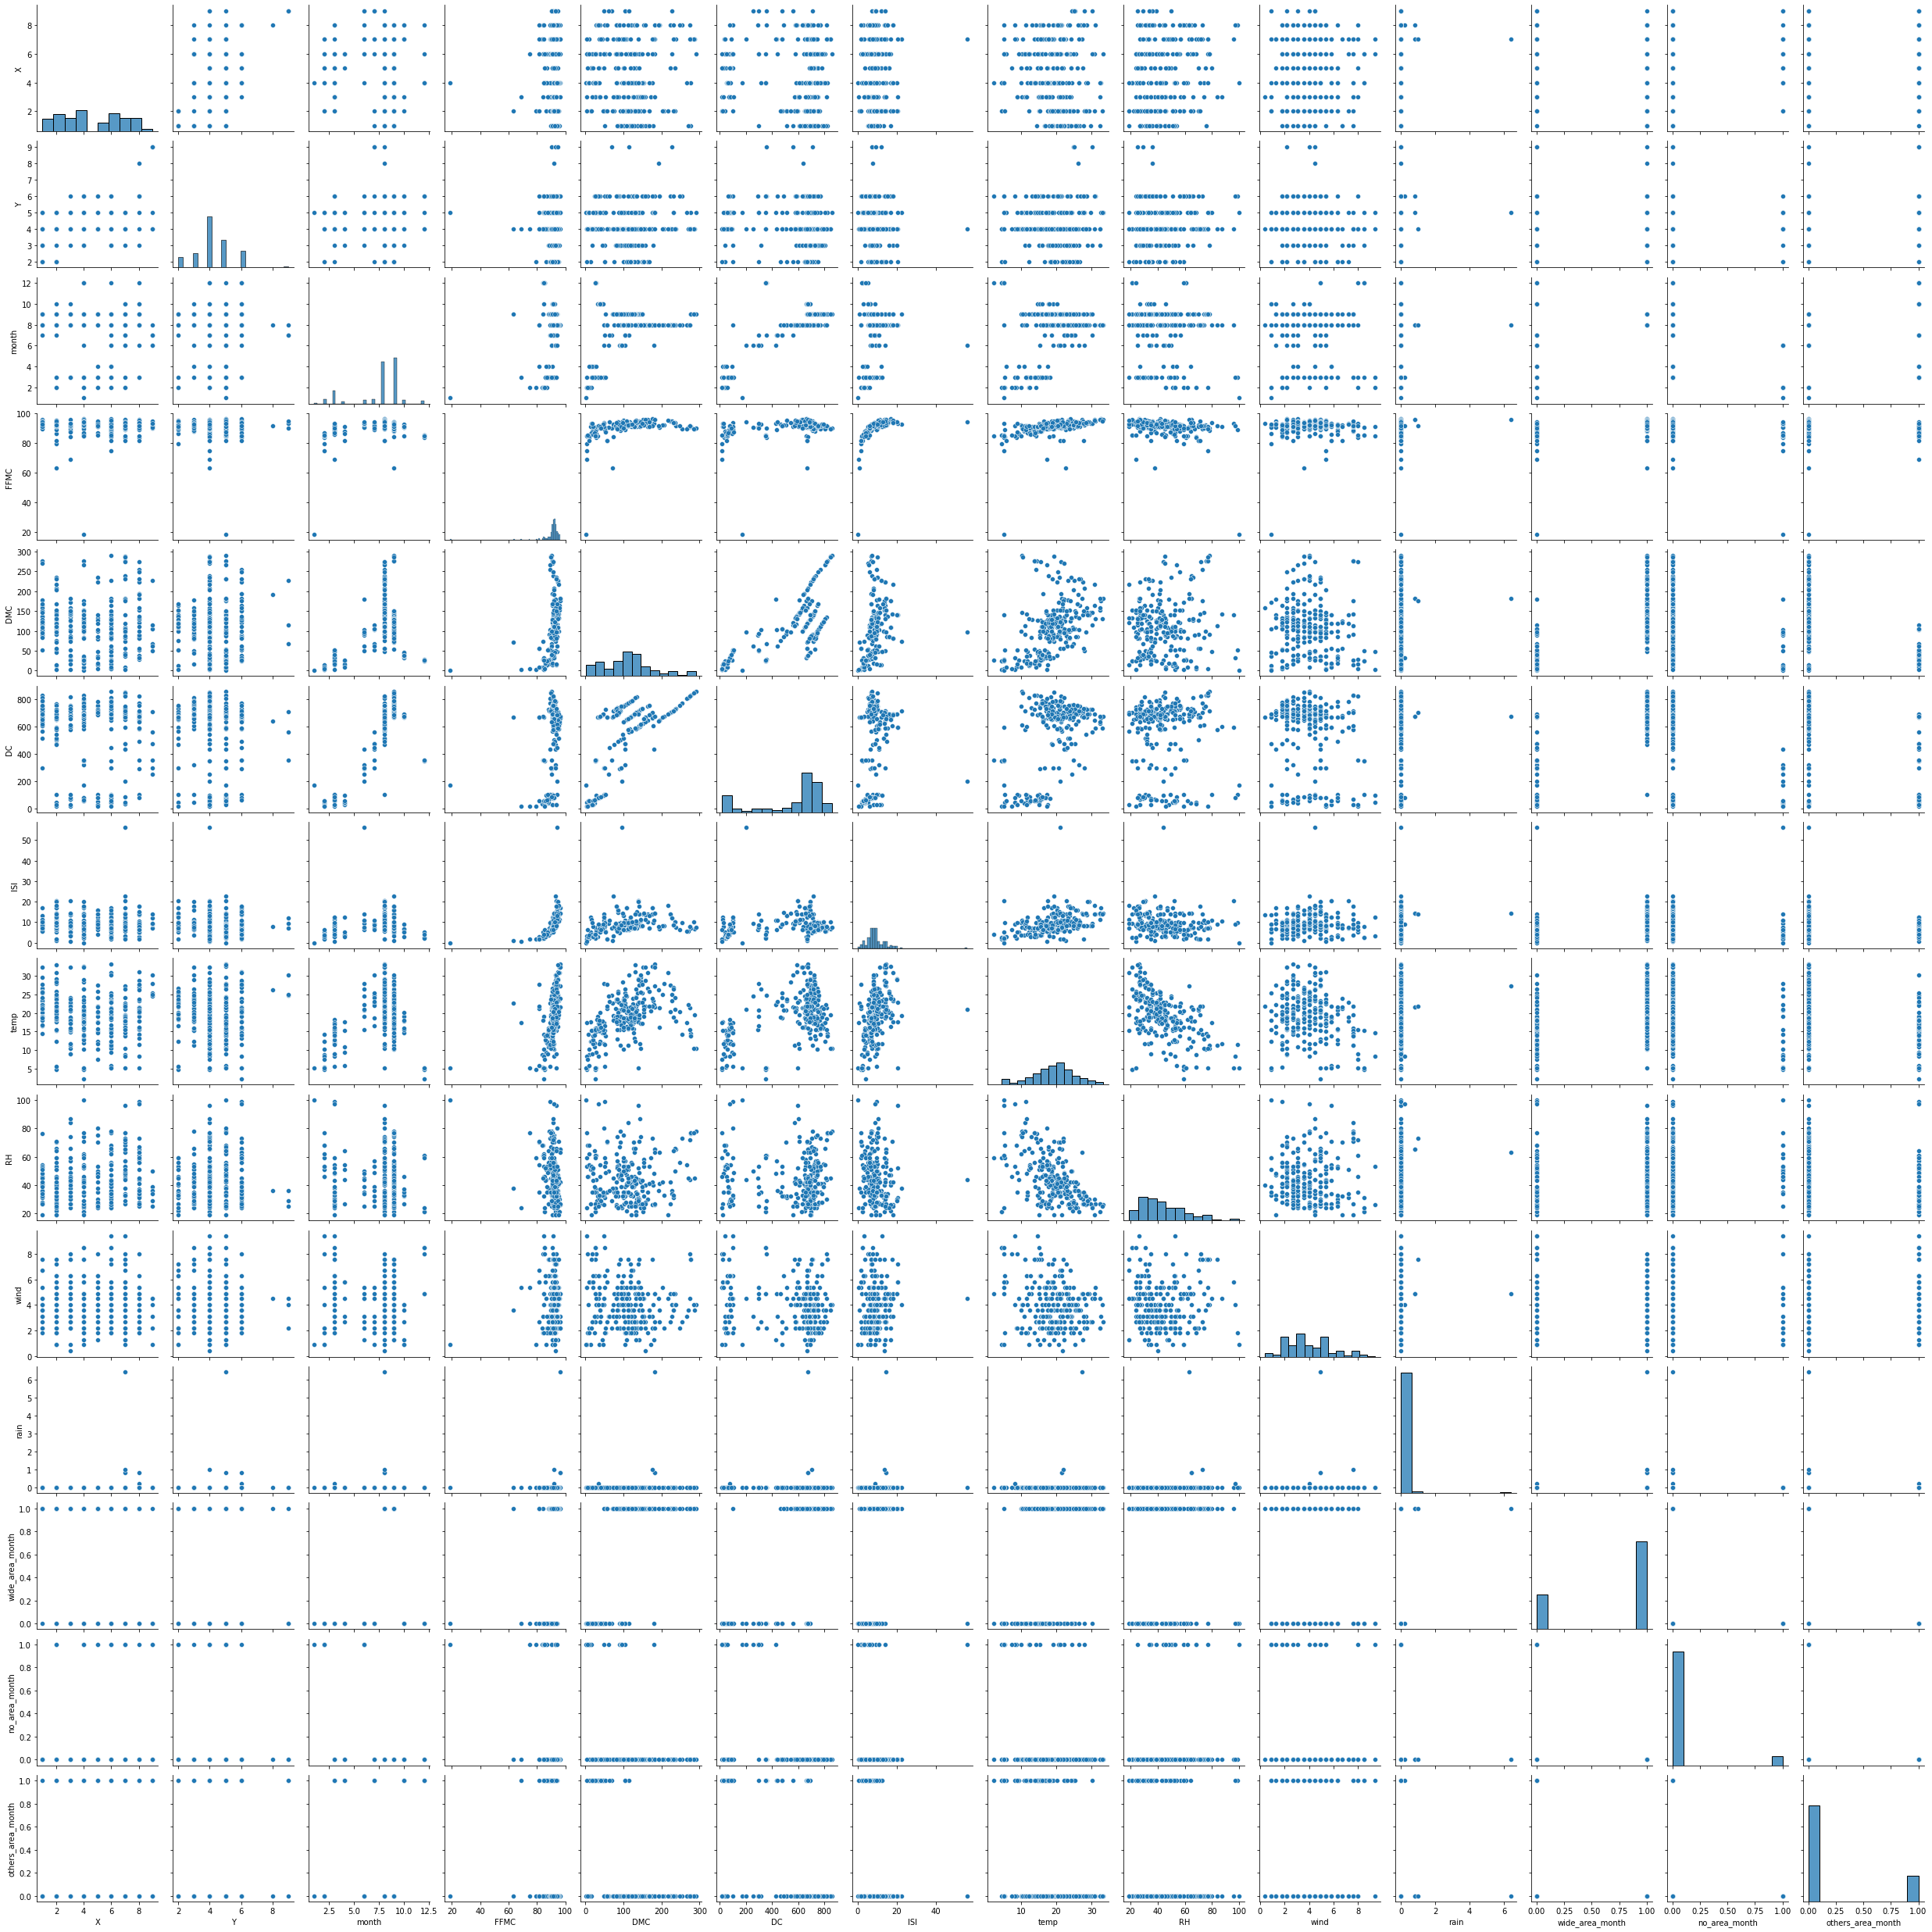

In [197]:
sns_plot = sns.pairplot(test)
sns_plot.savefig("img_test.png")

---
## `カラム名「rain」について`

In [208]:
train.rain.max()

1.4

In [209]:
train[train.rain!=0]

,X,Y,month,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,wide_area_month,no_area_month,others_area_month
id,,,,,,,,,,,,,,,
62,7,6,7,91.2,183.1,437.7,12.5,12.6,90,7.6,0.2,0.00,0,0,1
192,5,4,8,91.0,166.9,752.6,7.1,21.1,71,7.6,1.4,2.17,1,0,0
275,4,4,8,96.1,181.1,671.2,14.3,20.7,69,4.9,0.4,0.00,1,0,0


+ 降水量がある日でも消失面積がある日にちがある

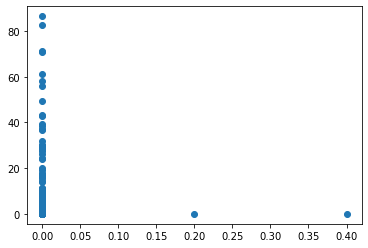

In [204]:
plt.scatter(train.rain[train.rain!=1.4], train.area[train.rain!=1.4])

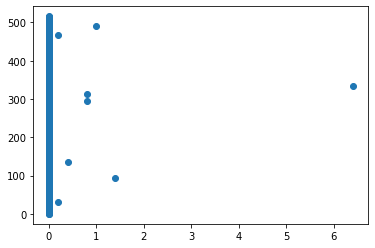

In [206]:
plt.scatter(data.rain, range(len(data)))

---
## `カラム名「FFMC」について`

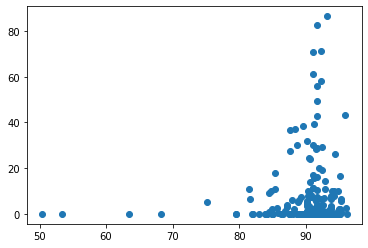

In [229]:
plt.scatter(train.FFMC, train.area)

+ FFMCが大きいと消失面積も大きくなる

## `特に問題なし、データの前処理一旦終了`

---
# `ランダムフォレストで特徴量の重要度測定`

In [185]:
x = train.drop("area", axis=1)
y = train["area"]

In [214]:
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

rf_reg = RandomForestRegressor(n_estimators=10, random_state=0)
rf_reg = rf_reg.fit(x, y)

fti = rf_reg.feature_importances_

dic_arr = {'importance':fti, 'feature':x.columns}
pd.DataFrame(dic_arr).sort_values('importance', ascending=False).reset_index(drop=True).loc[:13, :]

,importance,feature
0,0.197654,DMC
1,0.157974,DC
2,0.141388,ISI
3,0.117161,temp
4,0.090068,X
5,0.084939,wind
6,0.061055,FFMC
7,0.059573,RH
8,0.053860,Y
9,0.022199,month


In [233]:
# 特徴量選択（特徴量Xまで選択）
feature_x = ["DMC", "DC", "ISI", "temp", "X"]
data_x = train[feature_x]
test = test[feature_x]

In [234]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split,ShuffleSplit, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor

X_train,X_test,y_train,y_test = train_test_split(data_x,
                                                 y,
                                                 test_size=0.20,
                                                 random_state=1)

# pipeline setting
pipelines = {
     'ols': Pipeline([('scl',StandardScaler()),
                      ('est',LinearRegression())]),
     
     'ridge':Pipeline([('scl',StandardScaler()),
                       ('est',Ridge(random_state=0))]),

     'tree': Pipeline([('scl',StandardScaler()),
                     ('est',DecisionTreeRegressor(random_state=0))]),

     'rf': Pipeline([('scl',StandardScaler()),
                     ('est',RandomForestRegressor(random_state=0))]),
     
     'gbr1': Pipeline([('scl',StandardScaler()),
                      ('est',GradientBoostingRegressor(random_state=0))]),

     'gbr2': Pipeline([('scl',StandardScaler()),
                      ('est',GradientBoostingRegressor(n_estimators=200,
                                                       random_state=0))])
}

In [235]:
from sklearn.metrics import r2_score
scores = {}
for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    scores[(pipe_name,'train')] = r2_score(y_train, pipeline.predict(X_train))
    scores[(pipe_name,'test')] = r2_score(y_test, pipeline.predict(X_test))
 
pd.Series(scores).unstack()

,test,train
gbr1,-1.238974,0.905431
gbr2,-1.493452,0.971879
ols,-0.063145,0.007811
rf,-0.733853,0.850266
ridge,-0.062857,0.007810
tree,-4.055835,1.000000


In [154]:
#conda install -c conda-forge lightgbm

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/kiiiita/.pyenv/versions/anaconda3-2020.11/envs/main_notebook_env

  added / updated specs:
    - lightgbm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.5.30  |       h033912b_0         136 KB  conda-forge
    certifi-2021.5.30          |   py37hf985489_0         141 KB  conda-forge
    lightgbm-3.1.1             |   py37h23ab428_0         862 KB
    ------------------------------------------------------------
                                           Total:         1.1 MB

The following NEW packages will be INSTALLED:

  lightgbm           pkgs/main/osx-64::lightgbm-3.1.1-py37h23ab428_0

The following packa

---
# LightGBMモデル

In [332]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

# scaler = StandardScaler()
# scaler.fit(X_train)
# scaler.transform(X_train)
# scaler.transform(X_test)
# scaler.transform(test)

param_grid = {'boosting_type': ['gbdt'], 
              'class_weight': [None],
              'colsample_bytree': [0.9, 0.8, 0.7],
              'importance_type': ['split'],
              'learning_rate': [0.05, 0.04, 0.03, 0.1],
              'max_depth': [2],
              'min_child_samples': [2],
              'min_child_weight': [0],
              'min_split_gain': [0],
              'n_estimators': [200],
              'n_jobs': [-1],
              'num_leaves': [3],
              'objective': [None],
              'random_state': [None],
              'reg_alpha': [0.001, 0.01, 0.1, 1, 10],
              'reg_lambda': [0.01, 0.1, 1, 10],
              'silent': [True],
              'subsample': [0.1],
              'subsample_freq': [0]}

tune_model = GridSearchCV(lgb.LGBMRegressor(), param_grid=param_grid,
                                          scoring = 'neg_mean_squared_error', cv = cv_split,return_train_score=True)
tune_model.fit(X_train, y_train)

print("Training score mean: {:.5f}". format
      (np.sqrt(abs(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]))))
print("Test score mean: {:.5f}". format
      (np.sqrt(abs(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]))))

Training score mean: 11.26179
Test score mean: 13.83791


In [333]:
print(r2_score(y_test, tune_model.predict(X_test)))

ValueError: Number of features of the model must match the input. Model n_features_ is 5 and input n_features is 6 

---
## `予測値を出す`

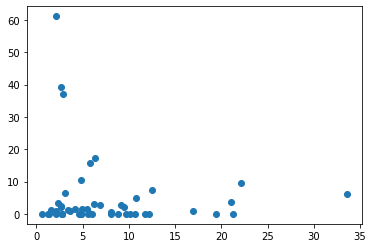

In [334]:
plt.scatter(pred_xtest, y_test)

In [335]:
# 一回目提出
pred = tune_model.predict(test)
for i in range(len(pred)):
    if pred[i]<=2:
        pred[i] = 0

In [336]:
index = pd.DataFrame(test.index)
index = index.rename(columns={"id":0})
pred = pd.DataFrame(pred)
pred = pred.rename(columns={0:1})

submit = pd.concat([index, pred], axis=1)

submit.set_index(0, inplace=True)

In [339]:
submit

,1
0,
1,6.796997
2,6.779084
4,4.707559
5,2.908645
6,0.000000
...,...
508,3.750260
512,4.924391
513,4.390204


In [341]:
submit.to_csv("second_repo.csv", header=None)